* Для работы 1 раз запустить первый и второй блок. Запускать блок можно, нажав на него мышкой, а затем нажав Cell->Run в верхнем меню.
* Далее работаем только в блоке 3, стирая символ '#' у необходимых в данный момент строк.
* В файле 1.json каходятся настройки программы. Обязательно поменять значение ключа 'path', на путь к папке landsat. Изменение остальных настроек опционально.

In [3]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [4]:
%%cython
import os
import simplejson
import numpy as np
cimport numpy as np
cimport cython
import skimage.io
import matplotlib

# class for one scene analyse
cdef class Scene:
    cdef public int id, bit
    cdef object json, path
    
    def __init__(self, _id_, config_file='2.json'):
        self.id = _id_
        with open(config_file) as data_file:    
            self.json = simplejson.load(data_file)
        self.bit = int(self.json['scenes'][self.id]['bit'])
        self.path = self.json['scenes'][self.id]['path']
    
    def read_images(self, path):
        return {'red': skimage.io.imread(os.path.join(self.json['path'], self.json['paths'][path], 'red',
                                                     self.path +  self.json['suffs'][path])),
                'nir': skimage.io.imread(os.path.join(self.json['path'], self.json['paths'][path], 'nir',
                                                     self.path +  self.json['suffs'][path]))}
    
    def is_in_mask(self, unsigned short val):
        return val < 64000 if self.bit == 16 else val < 253
    
    def normalize_imgs(self, img_red, img_nir):
        arr_n = np.genfromtxt(os.path.join(self.json['path'], self.json['paths']['docs'], self.json['docs']['n']), 
                              delimiter=',')[self.id]
        img_red_n = (img_red.astype(np.float) - arr_n[0]) / arr_n[1]
        img_nir_n = (img_nir.astype(np.float) - arr_n[2]) / arr_n[3]
        img_red_n[img_red <= 0] = -99
        img_nir_n[img_red <= 0] = -99
        return img_red_n, img_nir_n
        
    def get_plot_array(self, imgs):
        cdef np.ndarray[np.uint16_t, ndim = 2] img_red = imgs['red'].astype('uint16', copy = False)
        cdef np.ndarray[np.uint16_t, ndim = 2] img_nir = imgs['nir'].astype('uint16', copy = False)
        sizes = self.json['plotSizes'][str(self.bit)]
        cdef int sn0 = sizes['nir'][0], sn1 = sizes['nir'][1], sr0 = sizes['red'][0], sr1 = sizes['red'][1]
        cdef np.ndarray[np.int32_t, ndim = 2] plot_array = np.zeros([sr1 - sr0 + 1, sn1 - sn0 + 1], dtype = 'int32')
        cdef int x, y
        for x in range(img_red.shape[1]):
            for y in range(img_red.shape[0]):
                if self.is_in_mask(img_red[y, x]) and self.is_in_mask(img_nir[y, x]) \
                    and sr0 <= img_red[y, x] <= sr1 and sn0 <= img_nir[y, x] <= sn1:
                        plot_array[img_nir[y, x] - sn0, img_red[y, x] - sr0] += 1
        return plot_array
    
    def save_plot_array(self, plot_array):
        matplotlib.image.imsave(os.path.join(self.json['path'], self.json['paths']['notMarkedPlots'], 
                                             self.path + self.json['suffs']['markedPlots']), 
                                plot_array[::-1, :])
    def make_solp_scene(self):
        imgs = self.read_images('inFiltered')
        cdef np.ndarray[np.uint16_t, ndim = 2] img_red = imgs['red'].astype('uint16', copy = False)
        cdef np.ndarray[np.uint16_t, ndim = 2] img_nir = imgs['nir'].astype('uint16', copy = False)
        sizes = self.json['plotSizes'][str(self.bit)]
        cdef int sn0 = sizes['nir'][0], sn1 = sizes['nir'][1], sr0 = sizes['red'][0], sr1 = sizes['red'][1]
        cdef np.ndarray[np.uint8_t, ndim = 3] plot_marked = skimage.io.imread(
            os.path.join(self.json['path'], self.json['paths']['markedPlots'], 
                         self.path + self.json['suffs']['markedPlots']))
        cdef np.ndarray[np.uint8_t, ndim = 2] colors = \
            np.array(self.json['colorsMarkedPlots']).astype('uint8', copy = False)
        cdef int x, y, need_white, red, nir, color_eps = 9, color_sum, c, cs
        for x in range(img_red.shape[1]):
            for y in range(img_red.shape[0]):
                red, nir = img_red[y, x], img_nir[y, x]
                need_white = 1
                if sr0 <= red <= sr1 and sn0 <= nir <= sn1:
                    for c in range(colors.shape[0]):
                        color_sum = 0
                        for cs in range(3):
                            color_sum += abs(colors[c, cs] - plot_marked[sn1 - nir - 1, red - sr0, cs]) # TODO -1
                        if (color_sum <= color_eps):
                            need_white = 0
                            break
                if need_white == 1:
                    img_nir[y, x] = img_red[y, x] = 65535 # if self.bit == 16 else 255
        for img in [[img_red, 'red'], [img_nir, 'nir']]:
            skimage.io.imsave(os.path.join(self.json['path'], self.json['paths']['solp'], img[1], 
                                           self.path + self.json['suffs']['solp']), 
                              img[0].astype('uint' + str(self.bit)), plugin = 'tifffile')
    
    def get_soil_line(self, imgs):
        cdef np.ndarray[np.uint16_t, ndim = 2] img_red = imgs['red'].astype('uint16', copy = False)
        cdef np.ndarray[np.uint16_t, ndim = 2] img_nir = imgs['nir'].astype('uint16', copy = False)
        cdef np.ndarray[np.uint16_t, ndim = 1] red = np.zeros([img_red.size], dtype = 'uint16')
        cdef np.ndarray[np.uint16_t, ndim = 1] nir = np.zeros([img_red.size], dtype = 'uint16')
        cdef int x, y, size = 0
        for x in range(img_red.shape[1]):
            for y in range(img_red.shape[0]):
                if self.is_in_mask(img_red[y, x]) and self.is_in_mask(img_nir[y, x]):
                    red[size] = img_red[y, x]
                    nir[size] = img_nir[y, x]
                    size += 1
        red = np.resize(red, size)
        nir = np.resize(nir, size)
        return np.linalg.lstsq(np.vstack([red, np.ones(len(red))]).T, nir)[0]
                    
    cdef brat_vec(self, np.ndarray[np.uint16_t, ndim = 2] img_red, np.ndarray[np.uint16_t, ndim = 2] img_nir,
        int pnt_x, int pnt_y, int rad, float line_a, float line_b):
        cdef float res_x = 0, res_y = 0, ave_x = 0, ave_y = 0, ave_subj = 0
        cdef int n = 0, x, y
        for y in xrange(max(pnt_y - rad, 0), min(pnt_y + rad, img_red.shape[0])):
            for x in xrange(max(pnt_x - rad, 0), min(pnt_x + rad, img_red.shape[1])):
                if (pnt_x - x) ** 2 + (pnt_y - y) ** 2 <= rad ** 2 \
                    and self.is_in_mask(img_red[y, x]) and self.is_in_mask(img_nir[y, x]):
                        n += 1
                        subj = float(-line_a) * img_red[y, x] - line_b + img_nir[y, x]
                        res_x += x * subj
                        res_y += y * subj
                        ave_x += x
                        ave_y += y
                        ave_subj += subj
        return {'xx': (res_x - ave_x * ave_subj) / float(n) if n > 0 else -9999,
               'yy': (res_y - ave_y * ave_subj) / float(n) if n > 0 else -9999,
               'avg': ave_subj / float(n) if n > 0 else -9999,
               'n': n}
    
    def brat_first(self):
        json_f1 = self.json['brat_first']
        imgs = self.read_images('in') # читать не отсюда
        cdef np.ndarray[np.uint16_t, ndim = 2] img_red = imgs['red'].astype('uint16', copy = False)
        cdef np.ndarray[np.uint16_t, ndim = 2] img_nir = imgs['nir'].astype('uint16', copy = False)
        cdef int rad = json_f1['rad'], x_pts = json_f1['xPts'], y_pts = json_f1['yPts']
        cdef int line_a, line_b
        line_a, line_b = self.get_soil_line(imgs)
        cdef int x_abs, y_abs, i, j, x, y, x_abs_0 = json_f1['xAbs0'], y_abs_0 = json_f1['yAbs0']
        cdef int x_abs_step = json_f1['xAbsStep'],  y_abs_step = json_f1['yAbsStep']
        cdef int need_comma = 0
        
        f = open(os.path.join(self.json['path'], self.json['paths']['bratTxt'], self.path + \
                              self.json['suffs']['bratTxt']), 'w')
        for i in range(x_pts):
            for j in range(y_pts):
                x = int(i / (x_pts - 1.0) * img_red.shape[1])
                y = int(j / (y_pts - 1.0) * img_red.shape[0])
                x_abs = x_abs_0 + x * x_abs_step
                y_abs = y_abs_0 + y * y_abs_step
                vec = self.brat_vec(img_red, img_nir, x, y, rad, line_a, line_b)
                if need_comma:
                    f.write(',')
                f.write('{{%i,%i},{%i,%i},{%f,%f},%f,%i}\n' % 
                        (x, y, x_abs, y_abs, float(vec['xx']), float(vec['yy']), float(vec['avg']), vec['n']))
                if not need_comma:
                    need_comma = 1
        f.write('}')
        f.close()
        
cdef class SceneGroup:
    cdef object json, config_file
    
    def __init__(self, config_file='2.json'):
        self.config_file = config_file
        with open(config_file) as data_file:    
            self.json = simplejson.load(data_file)
    
    cdef make_axy_from_all(self, np.ndarray[np.float64_t, ndim=2] imgs):
        cdef int i, n 
        cdef np.ndarray[np.float64_t, ndim=1] reds, nirs
        cdef np.ndarray[np.float64_t, ndim=2] axy = np.ones((imgs.shape[0], 3)) * -99
        n = imgs.shape[1] / 2
        for i in range(imgs.shape[0]):
            reds = imgs[i, :n]
            reds = reds[reds != -99]
            nirs = imgs[i, n:]
            nirs = nirs[nirs != -99]
            if len(reds) > 1:
                axy[i, 0] = np.linalg.lstsq(np.vstack([reds, np.ones(len(reds))]).T, nirs)[0][0]
                axy[i, 1] = np.mean(reds) + np.mean(nirs)
                axy[i, 2] = np.mean(reds) - np.mean(nirs)
            if len(reds) != len(nirs):
                print(i)
        return axy
    
    def make_X_from_coords(self, coords):
        n = len(self.json['scenes'])
        imgs = np.empty((len(coords), n * 2), dtype=np.float)
        for i in range(n):
            S = Scene(i, config_file=self.config_file)
            img_red = S.read_images('solp')['red']
            img_nir = S.read_images('solp')['nir'] ### ^^^
            img_red, img_nir = S.normalize_imgs(img_red, img_nir) ### ^^^
            imgs[:, i] = img_red[coords[:, 0], coords[:, 1]]
            imgs[:, n + i] = img_nir[coords[:, 0], coords[:, 1]]
        return self.make_axy_from_all(imgs) ### <<<
    
    

In [17]:
%%time
### Paint .png and .tif maps


import numpy as np
import simplejson
import matplotlib.pyplot as plt
%matplotlib inline

config_file = '2.json'
with open(config_file) as data_file:    
    json = simplejson.load(data_file)
height, width = json['size']['height'], json['size']['width']
coords = np.array(np.meshgrid(range(height), range(width))).T.reshape(height * width, 2)
X_ = SceneGroup(config_file).make_X_from_coords(coords) # .reshape((height, width, 3))

arr_c = np.genfromtxt(json['docs']['c'], delimiter=',')
arr_6 = np.genfromtxt(json['docs']['6'], delimiter=',')
X = (X_ - arr_6[:, 0]) / arr_6[:, 1]
ans_c = np.zeros((X.shape[0],), dtype=np.uint8)
min_dist = np.ones((X.shape[0],), dtype=np.int) * 100500
for i, c in enumerate(arr_c):
    dist = np.sum((X - c) ** 2, axis=1)
    ans_c[min_dist > dist] = i + 1
    min_dist = np.minimum(min_dist, dist)
ans_c[X[:, 0] == -99] = 0
ans_c = ans_c.reshape((height, width))
matplotlib.image.imsave('pixel_map.png', ans_c, cmap='gnuplot2')
skimage.io.imsave('pixel_map.tif', ans_c)


CPU times: user 5min 39s, sys: 4.87 s, total: 5min 43s
Wall time: 6min 10s


In [50]:
%%time
### piecewise linear .csv

plinear = np.zeros((256, 35), dtype=np.float)
counts = np.zeros((256, 35), dtype=np.int)
for i in range(35):
    A = Scene(i)
    imgs = A.read_images('solp')
    if A.bit != 8:
        imgs['red'] /= 256
        imgs['nir'] /= 256
    for y in range(imgs['red'].shape[0]):
        for x in range(imgs['red'].shape[1]):
            plinear[imgs['red'][y, x], i] += imgs['nir'][y, x]
            counts[imgs['red'][y, x], i] += 1
    plinear[:, i] /= counts[:, i]
    plinear[:, i] = np.nan_to_num(plinear[:, i])

/home/fila/.local/lib/python3.5/site-packages/ipykernel/__main__.py:13: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/fila/.local/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/fila/.local/lib/python3.5/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in true_divide


CPU times: user 20min 39s, sys: 1.32 s, total: 20min 40s
Wall time: 20min 56s


(0, 90)

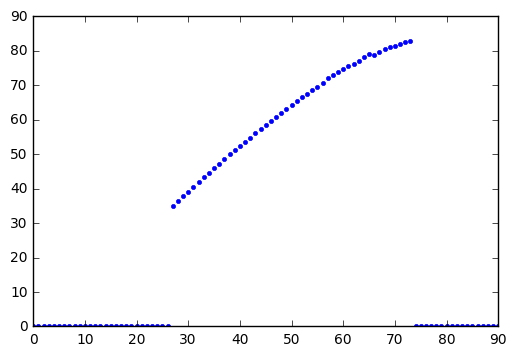

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(plinear[:, 16], '.')
plt.xlim([0, 90])

In [69]:
np.savetxt('plinear_R15.csv', plinear, fmt='%.4f')

In [ ]:
for i in range(5, 6):
    A = Scene(i)
    print 'calculating', i, 'scene...'
    # imgs = A.read_images('solp')
    print A.get_soil_line(imgs)
    plot_array = A.get_plot_array(imgs)
    # A.save_plot_array(plot_array)    # Эти 3 строчки для рисования графика
    # A.make_solp_scene()    # Эта строчка для фильтрации снимков по солпу с обведённых графиков
    # A.brat_first()    # Эта строчка для генерации txt брату

In [6]:
import os
in_path = '/home/fila/Downloads/2bands30/'
out_path = '/home/fila/Desktop/landsat2/solp/15/'
names = []
for name_full in os.listdir(in_path):
    name = name_full[:name_full.find('_')]
    names.append(name)
    img = skimage.io.imread(in_path + name_full)
    skimage.io.imsave(out_path + 'red/' + name + '.tif', img[:, :, 0], plugin='tifffile')
    skimage.io.imsave(out_path + 'nir/' + name + '.tif', img[:, :, 1], plugin='tifffile')
print(len(names))

35


In [47]:
import numpy as np
import pandas as pd
import simplejson
from sklearn.metrics import make_scorer

def class_cnt_metric(y, y_predict, need_print=False):
    res = 1.0
    probs = []
    for cl in range(y.max() + 1):
        aaa = y_predict[y == cl]
        pr = aaa[aaa == cl].shape[0] / aaa.shape[0]
        probs.append(pr)
        if pr < res:
            res = pr
    if need_print:
        return probs
    return res

def make_X_y_from_cuts(config_file='2.json'):
    with open(config_file) as data_file:    
        json = simplejson.load(data_file)

    df = pd.read_csv(json['docs']['cuts'])
    # print(df['nsoil2_k'].value_counts() / len(df['nsoil2_k']))

    X = SceneGroup(config_file).make_X_from_coords(df[['row', 'col']].as_matrix())
    y = df['nsoil2_k'].as_matrix()
    y = y[X[:, 0] != -99]
    # print(X.shape)
    X = X[X[:, 0] != -99].reshape(-1, X.shape[1])
    # print(X.shape)

    new_classes = [0, 0, 0, 1, 1, 1, 2, 2]
    for i in range(len(y)):
        y[i] = new_classes[y[i] - 1]
    
    return X, y

In [41]:
X, y = make_X_y_from_cuts()

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.svm import SVC

# scoring=make_scorer(class_cnt_metric)
# SVC(kernel='rbf'), {'C': [0.1, 1, 10, 100, 1000, 10000], 
#                                       'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

gs = GridSearchCV(SVC(kernel='rbf', probability=True), {'C': [0.1, 1, 10, 100, 1000, 10000], 
                                                        'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}, 
                  scoring=make_scorer(class_cnt_metric), cv=5, n_jobs=-1).fit(X, y)
print(gs.best_score_)
print(gs.best_params_)

0.720092855428
{'gamma': 1, 'C': 1000}


In [36]:
from sklearn.model_selection import train_test_split

res = []
for i in range(10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
    res.append(class_cnt_metric(y_test, gs.best_estimator_.fit(X_train, y_train).predict(X_test), need_print=True))
print(np.array(res).mean(axis=0))

[ 0.7640625   0.78863636  0.95542169]


In [5]:
%%time
import simplejson
import matplotlib.pyplot as plt

config_file = '2.json'
with open(config_file) as data_file:    
    json = simplejson.load(data_file)
height, width = json['size']['height'], json['size']['width']
coords = np.array(np.meshgrid(range(height), range(width))).T.reshape(height * width, 2)
X_all = SceneGroup(config_file).make_X_from_coords(coords)

CPU times: user 5min 15s, sys: 7.23 s, total: 5min 22s
Wall time: 5min 35s


In [6]:
import skimage.io

pr_all = gs.predict_proba(X_all)

cl = ['123', '456', '78']
for i, c in enumerate(cl):
    pr = pr_all[:, i]
    pr[X_all[:, 0] == -99] = 0
    skimage.io.imsave('pixel_map_' + c + '.png', (pr * 255).reshape((height, width)).astype(np.uint8))

In [54]:
for r in [2, 5, 15]:
    for n in ['disp', 'refl', 'reflshiftE', 'reflshiftshrink12']:
        with open('2.json') as data_file:    
            json = simplejson.load(data_file)
        json['paths']['solp'] = 'solp/' + str(r)
        json['docs']['n'] = 'res3b/nc/ncN' + n + '.csv'
        with open('tmp.json', 'w') as outfile:
            simplejson.dump(json, outfile)
            
        X, y = make_X_y_from_cuts('tmp.json')
        print('radius:', r, 'norm:', n)
        gs = GridSearchCV(SVC(kernel='rbf', probability=True), {'C': [0.1, 1, 10, 100, 1000, 10000], 
                                                        'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}, 
                  scoring=make_scorer(class_cnt_metric), cv=5, n_jobs=-1).fit(X, y)
        print(gs.best_score_)
        print(gs.best_params_)
        res = []
        for i in range(10):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
            res.append(class_cnt_metric(y_test, gs.best_estimator_.fit(X_train, y_train).predict(X_test), need_print=True))
        print(np.array(res).mean(axis=0))
        

radius: 2 norm: disp
0.632972458327
{'gamma': 0.1, 'C': 1000}
[ 0.65517241  0.72285714  0.9439759 ]
radius: 2 norm: refl
0.571080179811
{'gamma': 0.1, 'C': 10000}
[ 0.56206897  0.72571429  0.95421687]
radius: 2 norm: reflshiftE
0.568228233656
{'gamma': 0.1, 'C': 10000}
[ 0.61034483  0.7647619   0.94578313]
radius: 2 norm: reflshiftshrink12
0.583356072593
{'gamma': 0.1, 'C': 10000}
[ 0.61724138  0.77047619  0.9560241 ]
radius: 5 norm: disp
0.683064783248
{'gamma': 0.0001, 'C': 10000}
[ 0.69        0.77102804  0.95783133]
radius: 5 norm: refl
0.602718843256
{'gamma': 0.1, 'C': 10000}
[ 0.61        0.76728972  0.95361446]
radius: 5 norm: reflshiftE
0.593394980185
{'gamma': 1, 'C': 10000}
[ 0.65        0.75607477  0.94939759]
radius: 5 norm: reflshiftshrink12
0.587580070287
{'gamma': 1, 'C': 10000}
[ 0.58        0.77570093  0.94518072]
radius: 15 norm: disp
0.720092855428
{'gamma': 1, 'C': 1000}
[ 0.7625     0.78       0.9686747]
radius: 15 norm: refl
0.668226401698
{'gamma': 0.1, 'C': 100

In [22]:
print('i,red_mean,red_std,nir_mean,nir_std')
for i in range(35):
    S = Scene(i)
    imgs = S.read_images('solp')
    img_red, img_nir = imgs['red'], imgs['nir']
    print('{},{},{},{},{}'.format(i, img_red[img_red > 0].mean(), img_red[img_red > 0].std(),
             img_nir[img_nir > 0].mean(), img_nir[img_nir > 0].std()))

i,red_mean,red_std,nir_mean,nir_std
0,6966.8330078125,221.11648559570312,7797.2353515625,426.6827087402344
1,8358.1796875,448.5859375,10374.595703125,704.406494140625
2,7404.8427734375,219.97329711914062,8664.181640625,406.57086181640625
3,6345.2919921875,178.47552490234375,6733.07421875,302.6404724121094
4,6581.54150390625,106.15895080566406,7128.3232421875,238.45945739746094
5,8698.498046875,576.4619140625,11410.2119140625,1040.917724609375
6,35.891021728515625,1.678829550743103,34.88286209106445,2.240326404571533
7,61.52895736694336,10.560276985168457,43.73701477050781,7.5590901374816895
8,56.03553771972656,10.079209327697754,39.897422790527344,7.065771579742432
9,60.941001892089844,10.27199649810791,43.03665542602539,7.589703559875488
10,57.0288200378418,4.250854969024658,36.31740188598633,3.5975453853607178
11,30.869382858276367,1.7853554487228394,29.221168518066406,2.3376762866973877
12,63.26906967163086,10.929336547851562,44.13985061645508,8.022088050842285
13,35.73846435546875,

/usr/local/lib/python3.5/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:77: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


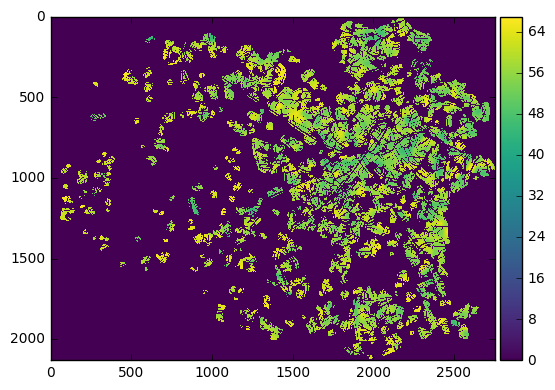

In [14]:
import skimage.io
%matplotlib inline
skimage.io.imshow(imgs['red'])

In [23]:
import pandas as pd
pd.read_csv('tmp.csv')

,i,red_mean,red_std,nir_mean,nir_std
0,0,6966.833008,221.116486,7797.235352,426.682709
1,1,8358.179688,448.585938,10374.595703,704.406494
2,2,7404.842773,219.973297,8664.181641,406.570862
3,3,6345.291992,178.475525,6733.074219,302.640472
4,4,6581.541504,106.158951,7128.323242,238.459457
5,5,8698.498047,576.461914,11410.211914,1040.917725
6,6,35.891022,1.678830,34.882862,2.240326
7,7,61.528957,10.560277,43.737015,7.559090
8,8,56.035538,10.079209,39.897423,7.065772
9,9,60.941002,10.271996,43.036655,7.589704


In [ ]:
ncN0 = {};
ncNdisp = {};
ncNshrinkd = {};
ncNshift = {};
ncNshiftshrinkd = {};
ncNrefl = ReadList[inFilePath <> "nc/nc" <> "Nrefl" <> ".txt"];
ncNreflshrink12 = {};
ncNreflshiftshrink12 = {};
ncNreflshiftE = {};

For[i = 1, i <= Length@LSnames, ++i,
    m1 = slA[[i]];
    m2 = slB[[i]];
    If[(m1 - ncNrefl[[i, 1, 1]])/ncNrefl[[i, 1, 2]] < 0, Print[i]];
    AppendTo[ncN0, {{0, 1}, {0, 1}}];
    AppendTo[
        ncNreflshrink12, 
        {
            {ncNrefl[[i, 1, 1]], ncNrefl[[i, 1, 2]]}, 
            {ncNrefl[[i, 2, 1]], ncNrefl[[i, 2, 2]] * Tan[(45 + 12)/180*Pi]}
        }
    ];
    AppendTo[
        ncNreflshiftshrink12, 
        {
            {m1, ncNrefl[[i, 1, 2]]}, 
            {m2, ncNrefl[[i, 2, 2]] * Tan[(45 + 12)/180*Pi]}
        }
    ];
    e1 = ncNrefl[[i, 1, 2]]; 
    e2 = ncNrefl[[i, 2, 2]] * Tan[(45 + 12)/180*Pi];
    k1 = m1 - ncNrefl[[i, 1, 1]];
    k2 = m2 - ncNrefl[[i, 2, 1]];
    AppendTo[
        ncNreflshiftE, 
        {
            {ncNrefl[[i, 1, 1]] + ( k1/e1 - k2/ e2)/2*(e1), ncNrefl[[i, 1, 2]]},
            {ncNrefl[[i, 2, 1]] + (k1/e1 - k2/ e2)/2*(-e2), ncNrefl[[i, 2, 2]] * Tan[(45 + 12)/180*Pi]}
        }
    ];
]